

# МОДЕЛЬ ДЛЯ ОПРЕДЕЛЕНИЯ ФОРМЫ ЛИЦА


In [ ]:
!git clone https://github.com/dsmlr/faceshape.git
%cd faceshape

Cloning into 'faceshape'...
remote: Enumerating objects: 535, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 535 (delta 0), reused 0 (delta 0), pack-reused 534 (from 1)
Receiving objects: 100% (535/535), 19.00 MiB | 42.95 MiB/s, done.
Resolving deltas: 100% (9/9), done.
/content/faceshape


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from collections import Counter
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# === Настройки ===
data_dir = "published_dataset"
batch_size = 32
epochs = 25
lr = 1e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# === Трансформации ===
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

In [ ]:
# === Датасет ===
dataset = datasets.ImageFolder(data_dir, transform=transform)
class_names = dataset.classes

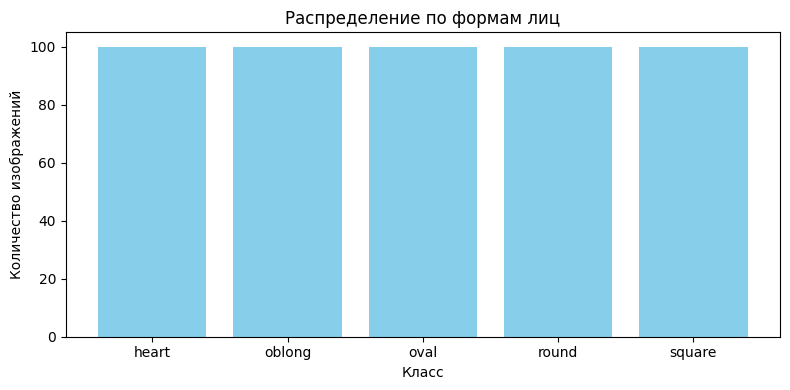

In [ ]:
# График: распределение по классам
labels = [label for _, label in dataset]
counts = Counter(labels)
plt.figure(figsize=(8, 4))
plt.bar([class_names[i] for i in counts.keys()], counts.values(), color='skyblue')
plt.title("Распределение по формам лиц")
plt.xlabel("Класс")
plt.ylabel("Количество изображений")
plt.tight_layout()
plt.show()

In [ ]:
# === Делим на train/val ===
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size)

In [ ]:
# === Модель ===
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(class_names))
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 135MB/s]


In [ ]:
# === Оптимизация ===
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [ ]:
# Для графиков
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

In [ ]:
# Обучение модели
best_val_acc = 0.0

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum()

    epoch_loss = running_loss / train_size
    epoch_acc = correct.double() / train_size
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc.item())

    model.eval()
    val_loss = 0.0
    val_correct = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum()

    val_epoch_loss = val_loss / val_size
    val_epoch_acc = val_correct.double() / val_size
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_acc.item())

    # Сохранение модели, если валидационная точность улучшилась
    if val_epoch_acc > best_val_acc:
        best_val_acc = val_epoch_acc
        torch.save(model.state_dict(), 'best_model.pth')

    print(f"[{epoch+1}/{epochs}] Train Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f} | Val Loss: {val_epoch_loss:.4f}, Acc: {val_epoch_acc:.4f}")

[1/25] Train Loss: 1.4882, Acc: 0.3300 | Val Loss: 1.2700, Acc: 0.4400
[2/25] Train Loss: 0.9853, Acc: 0.7000 | Val Loss: 1.1921, Acc: 0.5200
[3/25] Train Loss: 0.5714, Acc: 0.8775 | Val Loss: 1.2032, Acc: 0.5500
[4/25] Train Loss: 0.2745, Acc: 0.9500 | Val Loss: 1.3322, Acc: 0.5200
[5/25] Train Loss: 0.1255, Acc: 0.9775 | Val Loss: 1.3786, Acc: 0.5600
[6/25] Train Loss: 0.0952, Acc: 0.9850 | Val Loss: 1.3342, Acc: 0.5600
[7/25] Train Loss: 0.0565, Acc: 0.9975 | Val Loss: 1.3137, Acc: 0.5800
[8/25] Train Loss: 0.0450, Acc: 0.9875 | Val Loss: 1.3082, Acc: 0.5900
[9/25] Train Loss: 0.0521, Acc: 0.9875 | Val Loss: 1.1988, Acc: 0.6200
[10/25] Train Loss: 0.0472, Acc: 0.9900 | Val Loss: 1.2978, Acc: 0.5300
[11/25] Train Loss: 0.0432, Acc: 0.9925 | Val Loss: 1.3196, Acc: 0.6000
[12/25] Train Loss: 0.0474, Acc: 0.9900 | Val Loss: 1.5739, Acc: 0.5500
[13/25] Train Loss: 0.0381, Acc: 0.9900 | Val Loss: 1.6980, Acc: 0.5300
[14/25] Train Loss: 0.0474, Acc: 0.9850 | Val Loss: 1.4844, Acc: 0.5600
[

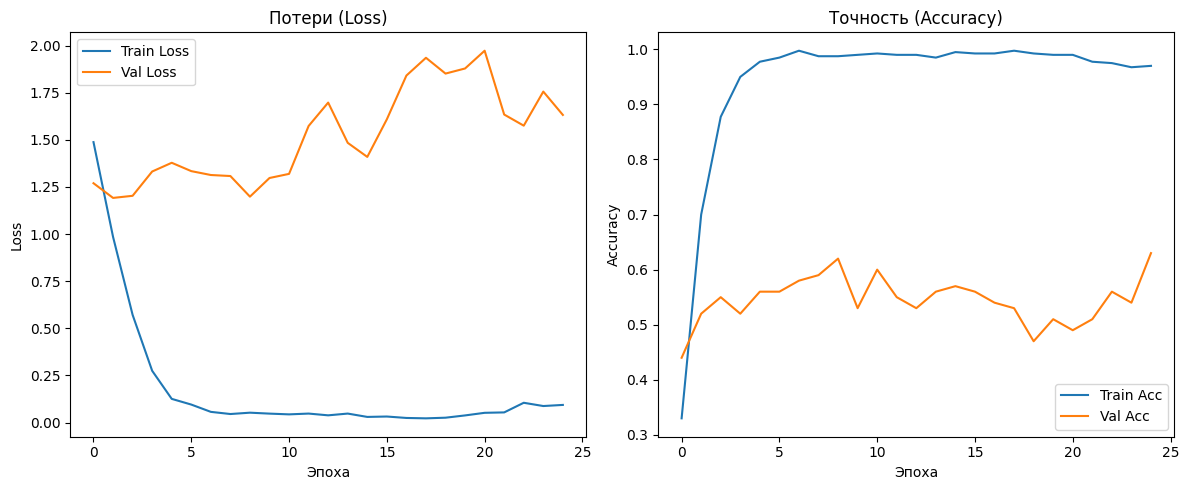

In [ ]:
# === Графики обучения ===
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Потери (Loss)")
plt.xlabel("Эпоха")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Acc")
plt.plot(val_accuracies, label="Val Acc")
plt.title("Точность (Accuracy)")
plt.xlabel("Эпоха")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

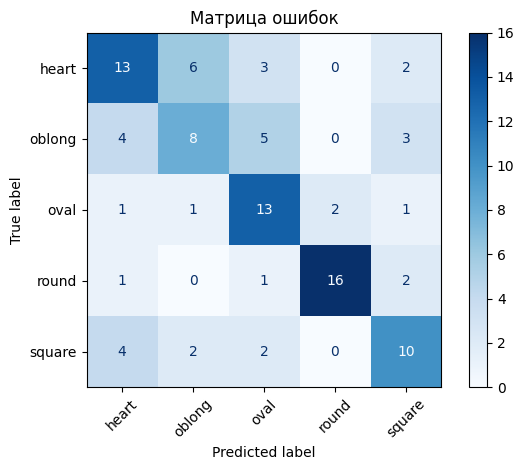

In [ ]:
# === Матрица ошибок ===
true_labels = []
pred_labels = []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Матрица ошибок")
plt.tight_layout()
plt.show()

In [ ]:
from PIL import Image
import torch
from torchvision import transforms, models
import os

# === Параметры ===
image_path = "test_face.jpg"
model_path = "face_shape_model.pth"
class_names = ['heart', 'oblong', 'oval', 'round', 'square']  # Классы из датасета
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Трансформация (такая же как и при обучении) ===
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# === Загрузка изображения ===
image = Image.open(image_path).convert('RGB')
image_tensor = transform(image).unsqueeze(0).to(device)

# === Загрузка модели ===
model = models.resnet50(pretrained=False)
model.fc = torch.nn.Linear(model.fc.in_features, len(class_names))
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

# === Предсказание ===
with torch.no_grad():
    outputs = model(image_tensor)
    _, predicted = torch.max(outputs, 1)
    predicted_class = class_names[predicted.item()]

print(f"Форма лица: {predicted_class}")

Форма лица: oblong
